In [13]:
import numpy as np
from typing import Iterable, Callable
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from mpl_toolkits.mplot3d import Axes3D

In [14]:
State = tuple[float, float]
Path = Iterable[State]

In [15]:
class Surface3:
    def __init__(self,
        f: Callable[[float, float], float],
        xlim: tuple[float, float] = (-5.0, 5.0),
        ylim: tuple[float, float] = (-5.0, 5.0),
        resolution: int = 100
    ) -> None:
        self.f = f
        self.xlim = xlim
        self.ylim = ylim
        self.resolution = resolution

        self.X, self.Y = np.meshgrid(
            np.linspace(*xlim, resolution),
            np.linspace(*ylim, resolution)
        )
        self.Z = self.f(self.X, self.Y)

    def __call__(self, x: float, y: float) -> float:
        return self.f(x, y)

    def plot_3d(self, ax: Axes, path: Path = None) -> None:
        ax.plot_surface(self.X, self.Y, self.Z, cmap="viridis", alpha=0.8)

        if path is not None:
            path = np.array(path)
            ax.plot(path[:, 0], path[:, 1], [self.f(x, y) for x, y in path], color="red", linewidth=0.5, zorder=3)

        ax.set_xlabel("x"); ax.set_ylabel("y")
        ax.set_zlabel("f(x, y)")

        ax.view_init(elev=60)

    def plot_2d(self, ax: Axes3D, path: Path = None) -> None:
        contour = ax.pcolormesh(self.X, self.Y, self.Z, cmap="viridis")
        plt.colorbar(contour)

        if path is not None:
            path = np.array(path)
            ax.plot(path[:, 0], path[:, 1], color="red", linewidth=0.5)

        ax.set_xlabel("x")
        ax.set_ylabel("f(x)")

    def plot(self, path: Path = None) -> None:
        fig = plt.figure(figsize=(20, 8))

        ax1 = fig.add_subplot(121, projection="3d")
        self.plot_3d(ax1, path)

        ax2 = fig.add_subplot(122)
        self.plot_2d(ax2, path)

        plt.tight_layout()

In [16]:
class Schedule:
    def __init__(self, s: Callable[[int], float]) -> None:
        self.s = s

    def __call__(self, t: int) -> float:
        return self.s(t)

In [17]:
class SimulatedAnnealing:
    def __init__(self,
        surface: Surface3,
        schedule: Schedule,
        start_state: State,
        step_size: float = np.pi / 32,
        random_state: int = None
    ) -> None:
        self.surface = surface
        self.schedule = schedule
        self.step_size = step_size
        self.current_state = start_state

        self.best_state = start_state
        self.best_value = surface(*start_state)

        self.path = [start_state]

        if random_state is None:
            random_state = np.random.SeedSequence().entropy

        self.seed = random_state
        self.random = np.random.default_rng(random_state)

    def get_neighbors(self, state: State) -> list[State]:
        neighbors = []
        state_x, state_y = state

        for angle in np.linspace(0, 2 * np.pi, 8, endpoint=False):
            dx = self.step_size * np.cos(angle)
            dy = self.step_size * np.sin(angle)

            neighbor = state_x + dx, state_y + dy
            neighbors.append(neighbor)

        return neighbors

    def accept(self, candidate_value: float, current_value: float, t: float) -> bool:
        if candidate_value > current_value:
            return True
        else:
            delta = candidate_value - current_value
            prob = np.exp(-delta / t)

            return self.random.random() < prob

    def search(self, max_iters: int = 1000) -> tuple[State, float, Path]:
        for t in range(max_iters):
            new_t = self.schedule(t)

            neighbors = self.get_neighbors(self.current_state)

            candidate = self.random.choice(neighbors)
            candidate_value = self.surface(*candidate)

            current_value = self.surface(*self.current_state)

            if self.accept(candidate_value, current_value, new_t):
                self.current_state = candidate

                self.path.append(candidate)

                if candidate_value > self.best_value:
                    self.best_state = candidate
                    self.best_value = candidate_value

        return self.best_state, self.best_value, self.path

Seed: 74995005620460379585308969832400541660
Best state: [ 9.9842254  -2.89760073]
Best value: 4.535004849464544
Path: [(0, 0), array([-0.06942005,  0.06942005]), array([0.02875472, 0.06942005]), array([-0.04066532,  0.        ]), array([-1.38840092e-01,  1.20229418e-17]), array([-0.20826014, -0.06942005]), array([-2.77680184e-01,  1.38777878e-17]), array([-0.20826014, -0.06942005]), array([-0.20826014, -0.16759482]), array([-0.13884009, -0.09817477]), array([-0.04066532, -0.09817477]), array([ 0.02875472, -0.02875472]), array([-0.04066532,  0.04066532]), array([-0.11008537,  0.11008537]), array([-0.04066532,  0.17950541]), array([-0.11008537,  0.11008537]), array([-0.0119106 ,  0.11008537]), array([0.05750945, 0.04066532]), array([ 0.05750945, -0.05750945]), array([ 0.12692949, -0.12692949]), array([ 0.05750945, -0.19634954]), array([-0.04066532, -0.19634954]), array([-0.13884009, -0.19634954]), array([-0.20826014, -0.12692949]), array([-0.27768018, -0.05750945]), array([-0.27768018, 

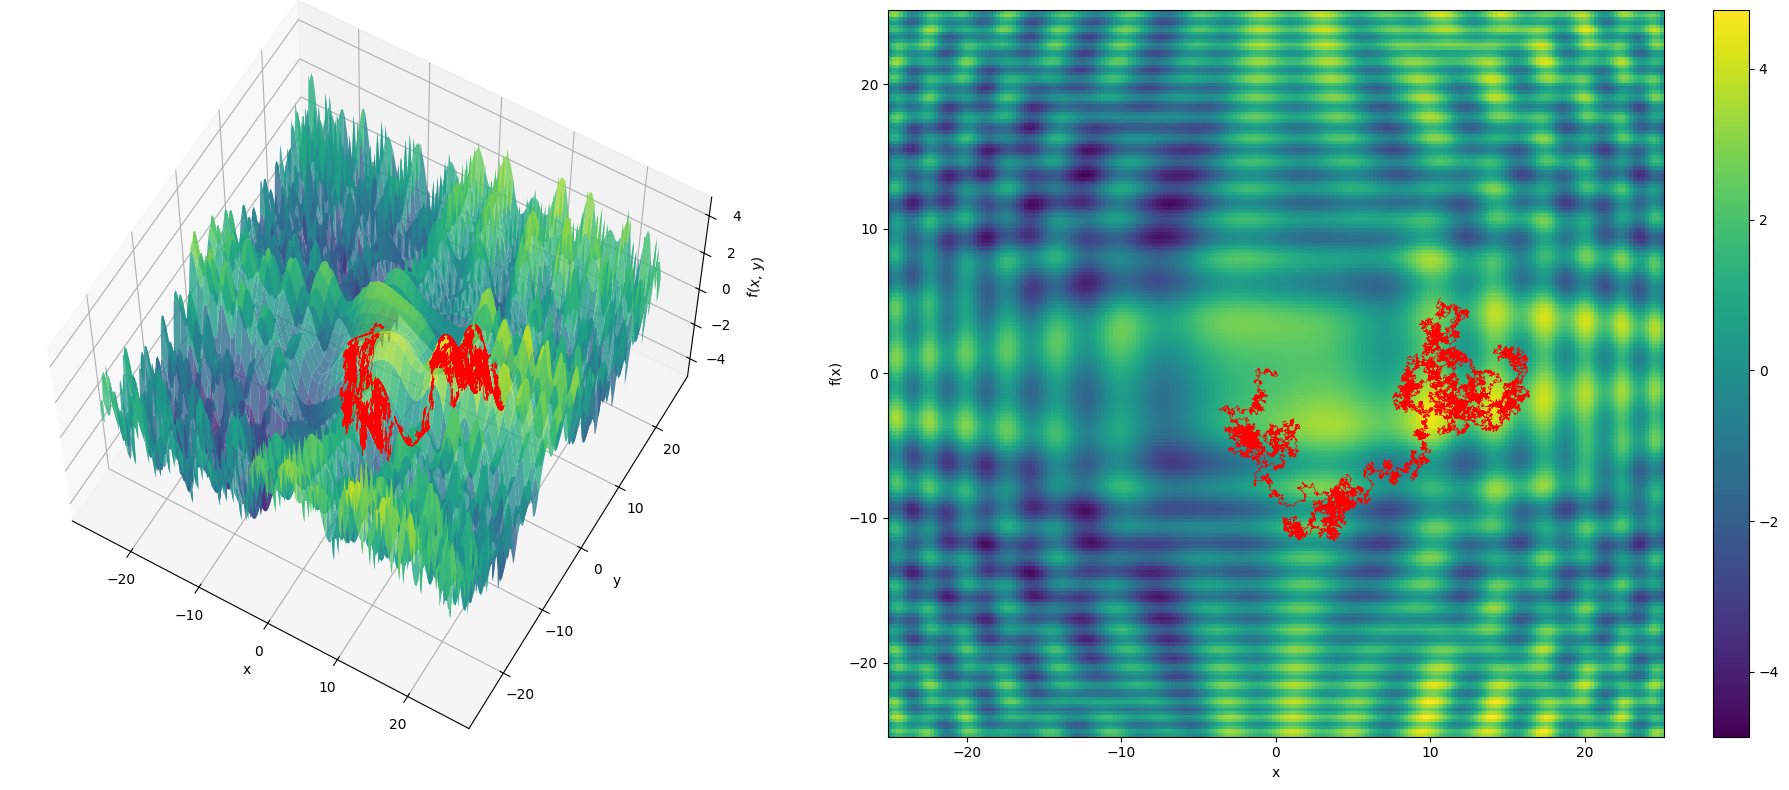

In [ ]:
BEST_SEED = 74995005620460379585308969832400541660

task1 = Surface3(
    lambda x, y: np.sin(x / 8) + np.cos(y / 4) - np.sin(x * y / 16) + np.cos(x ** 2 / 16) + np.sin(y ** 2 / 8),
    xlim=(-25.0, 25.0), ylim=(-25.0, 25.0), resolution=200
)

schedule = Schedule(lambda t: max(0.001, 1 / np.log(t + 2)))
simulated_anneal = SimulatedAnnealing(task1, schedule, (0, 0), random_state=BEST_SEED)

best_state, best_value, path = simulated_anneal.search(max_iters=20000)

print("\n".join([
    f"Seed: {simulated_anneal.seed}",
    f"Best state: {best_state}",
    f"Best value: {best_value}",
    f"Path: {path}"
]))

task1.plot(path)